In [54]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.models.feature_extraction import create_feature_extractor
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, ConcatDataset, TensorDataset

In [55]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = 'cpu'
print(f"Using {device} device")

Using cuda device


## CGAN (Vanilla)

In [56]:
def weights_init(m):
    """Initialize parameters/weights in GAN."""
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    return

In [57]:
class CondGenerator(torch.nn.Module):
    def __init__(self, num_class, channel_dim, latent_dim, embedding_dim, one_hot_encoding):
        super().__init__()
        self.num_class = num_class
        self.latent_dim = latent_dim
        if one_hot_encoding:
            self.embedding_dim = num_class
            self.label_in_channels = num_class
        else:
            self.embedding_dim = embedding_dim
            self.label_embedding = nn.Embedding(num_class, embedding_dim)
            self.label_in_channels = embedding_dim
        self.one_hot_encoding = one_hot_encoding

        self.label_channel = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=self.label_in_channels,
                out_channels=128,
                kernel_size=3,
                stride=1,
                bias=False,
            ),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.noise_channel = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=latent_dim,
                out_channels=128,
                kernel_size=3,
                stride=1,
                bias=False,
            ),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.G = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=0
            ),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(
                in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1
            ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(
                in_channels=64, out_channels=channel_dim, kernel_size=4, stride=2, padding=1
            ),
            nn.Tanh(),
        )

    def forward(self, z, y):
        """The forward function should return batch of images."""
        z = z.reshape(-1, self.latent_dim, 1, 1)
        if self.one_hot_encoding:
            y = F.one_hot(y, num_classes=self.num_class).float()
        else:
            y = self.label_embedding(y)
        y = self.label_channel(y.reshape(-1, self.embedding_dim, 1, 1))
        z = self.noise_channel(z)
        x = torch.cat((z, y), dim=1)
        x = self.G(x)
        return x

In [58]:
class CondDiscriminator(torch.nn.Module):
    def __init__(self, num_class, channel_dim, embedding_dim, one_hot_encoding):
        super().__init__()
        self.num_class = num_class
        self.channel_dim = channel_dim
        if one_hot_encoding:
            self.embedding_dim = num_class
            self.label_in_channel = num_class
        else:
            self.embedding_dim = embedding_dim
            self.label_embedding = nn.Embedding(num_class, embedding_dim)
            self.label_in_channel = embedding_dim
        self.one_hot_encoding = one_hot_encoding

        self.label_channel = nn.Sequential(
            nn.Conv2d(
                in_channels=self.label_in_channel,
                out_channels=32,
                kernel_size=4,
                stride=2,
                padding=1,
            ),
            nn.LeakyReLU(0.2),
        )
        self.img_channel = nn.Sequential(
            nn.Conv2d(
                in_channels=channel_dim,
                out_channels=32,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.LeakyReLU(0.2),
        )
        self.D = nn.Sequential(
            # half of the channels comes from the image, and the other half is from the label
            nn.Conv2d(
                in_channels=64,
                out_channels=128,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(
                in_channels=128,
                out_channels=256,
                kernel_size=3,
                stride=2,
                padding=0,
                bias=False,
            ),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(
                in_channels=256,
                out_channels=1,
                kernel_size=3,
                stride=1,
                padding=0,
                bias=False,
            ),
            nn.Flatten(),
            nn.Sigmoid(),
        )

    def forward(self, x, y):
        """The forward function should return the scores."""
        if self.one_hot_encoding:
            y = F.one_hot(y, num_classes=self.num_class).float()
        else:
            y = self.label_embedding(y)
        y = y[:, :, None, None].repeat(1, 1, 28, 28)
        y = self.label_channel(y)
        x = self.img_channel(x)
        x = torch.concat((x, y), dim=1)
        p = self.D(x)
        return p

In [59]:
class CDCGAN(object):
    def __init__(
        self, num_class, channel_dim, latent_dim, embedding_dim, one_hot_encoding, epochs, lr, device
    ):
        self.G = (
            CondGenerator(num_class, channel_dim, latent_dim, embedding_dim, one_hot_encoding)
            .apply(weights_init)
            .to(device)
        )
        self.D = (
            CondDiscriminator(num_class, channel_dim, embedding_dim, one_hot_encoding)
            .apply(weights_init)
            .to(device)
        )
        self.loss = nn.BCELoss()

        self.d_optimizer = torch.optim.Adam(
            self.D.parameters(), lr=lr, betas=(0.5, 0.999)
        )
        self.g_optimizer = torch.optim.Adam(
            self.G.parameters(), lr=lr, betas=(0.5, 0.999)
        )

        self.num_class = num_class
        self.one_hot_encoding = one_hot_encoding
        self.embedding_dim = embedding_dim
        self.channel_dim = channel_dim
        self.latent_dim = latent_dim
        self.epochs = epochs
        self.lr = lr
        self.device = device

    def train(self, train_loader, verbose_period=2):
        for epoch in range(self.epochs):
            total_d_loss = 0
            total_g_loss = 0
            num_batches = 0
            verbose = (epoch % verbose_period) == 0
            with tqdm(train_loader, unit="batch", disable=not verbose) as bar:
                bar.set_description(f"Epoch {epoch}")
                for images, y in bar:
                    batch_size = images.size(0)
                    # Step 1: Train discriminator
                    z = torch.randn((batch_size, self.latent_dim)).to(self.device)

                    real_labels = torch.ones(batch_size)
                    fake_labels = torch.zeros(batch_size)

                    images, y = images.to(self.device), y.reshape(-1).to(self.device).long()

                    real_labels, fake_labels = real_labels.to(
                        self.device
                    ), fake_labels.to(self.device)

                    # Compute the BCE Loss using real images
                    real_scores = self.D(images, y)
                    real_scores = torch.squeeze(real_scores)
                    d_loss_real = self.loss(real_scores, real_labels)

                    # Compute the BCE Loss using fake images
                    fake_images = self.G(z, y)
                    fake_scores = self.D(fake_images, y)
                    fake_scores = torch.squeeze(fake_scores)
                    d_loss_fake = self.loss(fake_scores, fake_labels)

                    # Optimize discriminator
                    d_loss = d_loss_real + d_loss_fake
                    self.D.zero_grad()
                    d_loss.backward()
                    # max log(D(x)) + log(1 - D(G(z))) <=> min -[ log(D(x)) + log(1 - D(G(z))) ]
                    self.d_optimizer.step()

                    # Step 2: Train Generator
                    z = torch.randn(batch_size, self.latent_dim).to(self.device)

                    fake_images = self.G(z, y)
                    fake_scores = self.D(fake_images, y)
                    fake_scores = torch.squeeze(fake_scores)
                    g_loss = self.loss(fake_scores, real_labels)

                    self.D.zero_grad()
                    self.G.zero_grad()
                    g_loss.backward()
                    # min log(1 - D(G(z))) => min -[ log(D(G(z))) ]
                    self.g_optimizer.step()

                    # update bar
                    num_batches += 1
                    total_d_loss += d_loss.item()
                    total_g_loss += g_loss.item()
                    bar.set_postfix(
                        d_loss=float(total_d_loss / num_batches),
                        g_loss=float(total_g_loss / num_batches),
                    )
            if total_d_loss / num_batches < 1e-3 or total_g_loss / num_batches > 8:
                print(
                    f"Discriminator loss is too small and generator loss is too high at epoch:{epoch}, " +
                    "which indicate a potential saturation problem."
                )
                print("Now, re-initialize and re-train...")
                self.__init__(
                    self.num_class,
                    self.channel_dim,
                    self.latent_dim,
                    self.embedding_dim,
                    self.one_hot_encoding,
                    self.epochs,
                    self.lr,
                    self.device,
                )
                self.train(train_loader, verbose_period=verbose_period)
                return
        return

    def generate_img(self, number_of_images, class_label, channel_dim):
        samples = (
            self.G(
                torch.randn((number_of_images, self.latent_dim)).to(
                    self.device
                ),
                (class_label * torch.ones(number_of_images)).long().to(self.device),
            )
            .detach()
            .cpu()
            .reshape(-1, channel_dim, 28, 28)
        )
        samples = samples * 0.5 + 0.5
        return samples


## CNN

In [60]:
class CNN(nn.Module):
    def __init__(self, channel_dim, num_class, device):
        super().__init__()
        self.num_class = num_class
        self.device = device
        # download resnet
        resnet = torchvision.models.resnet50(weights="DEFAULT")
        resnet.conv1 = nn.Conv2d(channel_dim, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        resnet.fc = nn.Flatten()
        self.resnet = resnet
        self.fc = nn.Linear(in_features=2048, out_features=num_class, bias=True)
        self.to(device)


    def forward(self, x):
        embedding = self.resnet(x)
        p = F.softmax(self.fc(embedding), dim=1)
        return p, embedding

    def evaluate(self, dataloader):
        total_correct = 0
        total_loss = 0
        num_samples = len(dataloader.dataset)
        num_batches = 0
        criterion = nn.CrossEntropyLoss(reduction="mean")
        with torch.no_grad():
            for img_batch, label_batch in dataloader:
                img_batch = img_batch.to(self.device)
                label_batch = label_batch.to(self.device).reshape(-1)
                prob_batch, _ = self(img_batch)
                # loss
                total_loss += criterion(prob_batch, label_batch).item()
                num_batches += 1
                # num correct
                total_correct += (prob_batch.argmax(dim=1) == label_batch).sum().item()
        return total_loss / num_batches, total_correct / num_samples


    def train(self, train_dataloader, valid_dataloader, lr, epochs, save_best=False, fpath=None, verbose_period=1):
        history = {
            'loss': [],
            'val_loss': [],
            'acc': [],
            'val_acc': [],
        }
        criterion = nn.CrossEntropyLoss(reduction="mean")
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        if save_best:
            best_acc, best_epoch = 0, 0

        for epoch in range(epochs):
            total_correct = 0
            total_loss = 0
            num_samples = 0
            num_batches = 0
            verbose = (epoch % verbose_period) == 0
            with tqdm(train_dataloader, unit="batch", disable=not verbose) as bar:
                bar.set_description(f"Epoch {epoch}")
                for img_batch, label_batch in bar:
                    img_batch = img_batch.to(self.device)
                    label_batch = label_batch.to(self.device).reshape(-1)
                    # forward, backward & optimizer step
                    self.zero_grad()
                    prob_batch, _ = self(img_batch)
                    loss = criterion(prob_batch, label_batch)
                    loss.backward()
                    optimizer.step()
                    # update bar
                    total_loss += loss.item()
                    num_batches += 1
                    total_correct += (prob_batch.argmax(dim=1) == label_batch).sum().item()
                    num_samples += img_batch.shape[0]
                    bar.set_postfix(ce=float(total_loss/num_batches), acc=float(total_correct/num_samples))

            valid_loss, valid_acc = self.evaluate(valid_dataloader)
            if verbose:
                print("val_ce={:0.3f}, val_acc={:0.3f}".format(valid_loss, valid_acc))
            if save_best:
                if valid_acc > best_acc:
                    best_acc = valid_acc
                    best_epoch = epoch
                    print(f"Saving best model at epoch {best_epoch} with valid acc: {best_acc}")
                    torch.save(self, fpath)
            history['loss'].append(total_loss / num_batches)
            history['val_loss'].append(valid_loss)
            history['acc'].append(total_correct / num_samples)
            history['val_acc'].append(valid_acc)
        return history


    def calculate_embeddings(self, dataloader: DataLoader, verbose: bool = False):
        """Calculate embeddings for all images."""
        total_embedding = torch.zeros(len(dataloader.dataset), 2048).to(self.device)
        idx_curser = 0
        with torch.no_grad():
            for img_batch, _ in tqdm(dataloader, disable=not verbose):
                img_batch = img_batch.to(self.device)
                _, embedding_batch = self(img_batch)
                embedding_batch = embedding_batch.reshape(-1, 2048).detach()
                total_embedding[idx_curser : (idx_curser + len(img_batch)), :] = embedding_batch
                idx_curser += len(img_batch)
        return total_embedding




In [61]:
def generate_synthetic_images(
    G: CondGenerator,
    labels: torch.Tensor,
    channel_dim: int,
    device: str,
):
    number_of_images = len(labels)
    samples = (
        G(
            torch.randn((number_of_images, G.latent_dim)).to(device),
            labels.long().to(device),
        )
        .detach()
        .reshape(-1, channel_dim, 28, 28)
    )
    return samples

## Loading MedMNIST data

In [62]:
# %%capture
# !pip install medmnist

In [63]:
import medmnist
from medmnist import INFO, Evaluator

%matplotlib inline

In [64]:
data_flag = 'organamnist'
# data_flag = 'pneumoniamnist'
# data_flag = 'bloodmnist'


download = True

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [65]:
# organamnist
label_dict = {
    0: 'bladder',
    1: 'femur-left',
    2: 'femur-right',
    3: 'heart',
    4: 'kidney-left',
    5: 'kidney-right',
    6: 'liver',
    7: 'lung-left',
    8: 'lung-right',
    9: 'pancreas',
    10: 'spleen'
}

# # pneumoniamnist
# label_dict = {
#     0: "normal",
#     1: "pneumonia",
# }

# # bloodmnist
# label_dict = {
#     0: 'basophil',
#     1: 'eosinophil',
#     2: 'erythroblast',
#     3: 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)',
#     4: 'lymphocyte',
#     5: 'monocyte',
#     6: 'neutrophil',
#     7: 'platelet'
# }

In [66]:
print(f"n_channels: {n_channels}")
print(f"n_classes: {n_classes}")

n_channels: 1
n_classes: 11


In [67]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

root_path = 'content/'

# load the data
train_dataset_ = DataClass(split='train', transform=data_transform, download=download, root=root_path)
valid_dataset = DataClass(split='val', transform=data_transform, download=download, root=root_path)
test_dataset_ = DataClass(split='test', transform=data_transform, download=download, root=root_path)

train_dataset = torch.utils.data.ConcatDataset([train_dataset_, test_dataset_])

BATCH_SIZE = 128
# encapsulate data into dataloader form
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

Using downloaded and verified file: content/organamnist.npz
Using downloaded and verified file: content/organamnist.npz


Using downloaded and verified file: content/organamnist.npz


In [68]:
print(
    DataClass(split='train', transform=data_transform, download=download, root=root_path)
)

Using downloaded and verified file: content/organamnist.npz
Dataset OrganAMNIST (organamnist)
    Number of datapoints: 34581
    Root location: content/
    Split: train
    Task: multi-class
    Number of channels: 1
    Meaning of labels: {'0': 'bladder', '1': 'femur-left', '2': 'femur-right', '3': 'heart', '4': 'kidney-left', '5': 'kidney-right', '6': 'liver', '7': 'lung-left', '8': 'lung-right', '9': 'pancreas', '10': 'spleen'}
    Number of samples: {'train': 34581, 'val': 6491, 'test': 17778}
    Description: The OrganAMNIST is based on 3D computed tomography (CT) images from Liver Tumor Segmentation Benchmark (LiTS). It is renamed from OrganMNIST_Axial (in MedMNIST v1) for simplicity. We use bounding-box annotations of 11 body organs from another study to obtain the organ labels. Hounsfield-Unit (HU) of the 3D images are transformed into gray-scale with an abdominal window. We crop 2D images from the center slices of the 3D bounding boxes in axial views (planes). The images are

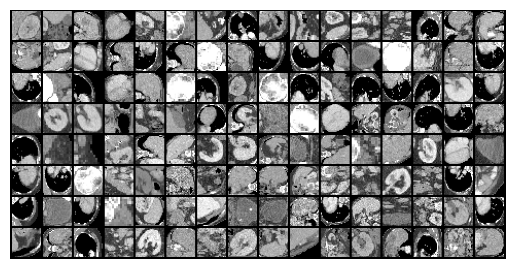

In [69]:
img_batch, label_batch = next(iter(train_loader))
img_batch = img_batch * 0.5 + 0.5
plt.imshow(
        torch.permute(
            make_grid(img_batch, nrow=16, padding=2), (1,2,0))
    )
plt.axis("off")
plt.show()

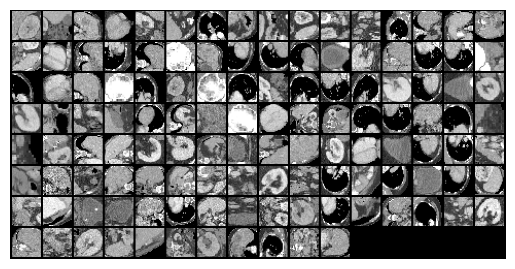

In [70]:
## grid imgs
plt.imshow(
        torch.permute(
            make_grid(img_batch[(1 - label_batch).reshape(-1).nonzero().reshape(-1)],
                      nrow=16, padding=2), (1,2,0))
    )
plt.axis("off")
plt.show()

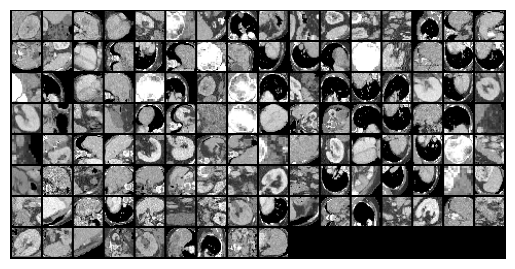

In [71]:
plt.imshow(
        torch.permute(
            make_grid(img_batch[label_batch.reshape(-1).nonzero().reshape(-1)],
                      nrow=16, padding=2), (1,2,0))
    )
plt.axis("off")
plt.show()

In [72]:
# cnn = CNN(channel_dim=n_channels, num_class=8, device=device)
# cnn.train(train_dataloader=train_loader, valid_dataloader=valid_loader, lr=1e-4, epochs=20)

## Training

In [73]:
def embedding_epoch_onehot_experiment(embedding_size,epoch_size,one_hot_encoding):
    model = CDCGAN(
        num_class=n_classes,
        channel_dim=n_channels,
        latent_dim=64,
        embedding_dim=embedding_size,
        one_hot_encoding=one_hot_encoding,
        epochs=epoch_size,
        lr=2e-4,
        device=device
    )
    return model

In [74]:
embedding_list = [4,8,32]
eopch_list = [10,100]

In [75]:

# for embedding_size in embedding_list:
#     for epochs_size in eopch_list:
#         one_hot_encoding = False
#         print('Start Training:############################################')
#         print(f'Embedding size : {embedding_size}, Epoch size : {epochs_size}, One hot encoding : {one_hot_encoding}')
#         model = embedding_epoch_onehot_experiment(embedding_size,epochs_size,one_hot_encoding)
#         model.train(train_loader, verbose_period=max(2,epochs_size//5))
#         model_path = 'content/model/'
#         model_path = model_path + f'{data_flag}_emb{embedding_size}_epo{epochs_size}_vanilla.pt'
#         torch.save(model.G, model_path)
#         print(f'Embedding size : {embedding_size}, Epoch size : {epochs_size}, One hot encoding : {one_hot_encoding}')
#         print('End Training:############################################')
# for epochs_size in eopch_list:
#     one_hot_encoding = True
#     print('Start Training:############################################')
#     print(f'Epoch size : {epochs_size}, One hot encoding : {one_hot_encoding}')
#     model = embedding_epoch_onehot_experiment(embedding_size,epochs_size,one_hot_encoding)
#     model.train(train_loader, verbose_period=max(2,epochs_size//5))
#     model_path = 'content/model/'
#     model_path = model_path + f'{data_flag}_OneHot_epo{epochs_size}__vanilla.pt'
#     torch.save(model.G, model_path)
#     print(f'Embedding size : {embedding_size}, Epoch size : {epochs_size}, One hot encoding : {one_hot_encoding}')
#     print('End Training:############################################')

## FID

In [76]:
from scipy.linalg import sqrtm

def get_class_weights(dataloader: DataLoader, num_class: int):
    """Calculate class weights in a dataloader."""
    if isinstance(dataloader.dataset, ConcatDataset):
        class_counts = np.zeros(num_class)
        datasets = dataloader.dataset.datasets
        for i in range(len(datasets)):
            class_counts += np.bincount(datasets[i].labels.reshape(-1))
        return class_counts / len(dataloader.dataset)
    elif isinstance(dataloader.dataset, Dataset):
        class_counts = np.bincount(dataloader.dataset.labels.reshape(-1))
        return class_counts / len(dataloader.dataset)
    else:
        raise TypeError("DataLoader.dataset type error")


def extract_class_k(dataloader: DataLoader, class_k: int):
    """Extract all data of class from dataloader. Output another dataloader."""
    img_list, label_list = [], []
    for img_batch, label_batch in dataloader:
        argwhere = (label_batch == class_k).view(-1)
        img_list.append(img_batch[argwhere])
        label_list.append(label_batch[argwhere])
    class_k_dataloader = DataLoader(
        TensorDataset(torch.concat(img_list), torch.concat(label_list)),
        batch_size=dataloader.batch_size,
        shuffle=True,
    )
    return class_k_dataloader


def fid_handler(
    mu_real: torch.Tensor, C_real: torch.Tensor, embedding_fake: torch.Tensor, m: int
):
    """Calculate Frechet Inception Distance.

    Let C denotes the normalized re-centered embeddings.
    C = 1/sqrt(m - 1) * (E - mu @ 1)
    FID = L2_norm(mean diff) + trace{Sigma_real + Sigma_fake - 2*sqrtm(Sigma_real @ Sigma_fake)}
    """
    # get fake mu and C
    mu_fake = embedding_fake.mean(dim=0)
    C_fake = (embedding_fake - mu_fake) / np.sqrt(m - 1)
    # difference between mu
    d_mu = mu_real - mu_fake
    # trace of Sigma
    tr_S_r = (C_real**2).sum()
    tr_S_f = (C_fake**2).sum()

    # trace of sqrtm(S_r S_f)
    M = ((C_fake @ C_real.T) @ C_real) @ C_fake.T

    tr_sqrtm = torch.sum(
        torch.sqrt(torch.linalg.eigvals(M)) #TODO: this is biased
    )
    # fid
    fid = d_mu @ d_mu + tr_S_r + tr_S_f - 2 * tr_sqrtm
    return fid


def fid(
    cnn: CNN,
    real_dataloader: DataLoader,
    generator: CondGenerator,
    B: int,
    m: int,
    num_class: int,
    channel_dim: int,
    device: str,
    unconditional: bool = True,
    class_label: int | None = None,
    verbose: bool = False,
):
    """Calculate FID."""
    # calculate E_r and its mu and C
    with torch.no_grad():
        if not unconditional:
            real_dataloader = extract_class_k(
                dataloader=real_dataloader, class_k=class_label
            )
        embedding_real = cnn.calculate_embeddings(real_dataloader, verbose)
        mu_real = embedding_real.mean(dim=0)
        N = embedding_real.shape[0]
        C_real = (embedding_real - mu_real) / np.sqrt(N - 1)
        # iterate B times
        for i in range(B):
            if unconditional:
                target_weights = get_class_weights(real_dataloader, num_class)
                target_weights = torch.tensor(target_weights)
                labels = torch.multinomial(target_weights, m, replacement=True)
            else:
                labels = class_label * torch.ones(m)
            # generate fake image & calculate embeddings
            fake_images = generate_synthetic_images(
                generator, labels, channel_dim, device
            )
            _, embedding_fake = cnn(fake_images)
            embedding_fake = embedding_fake.reshape(-1, 2048).detach()
            fid = fid_handler(mu_real, C_real, embedding_fake, m)
            print("fid =", float(fid.real))
    if device == "cuda":
        torch.cuda.empty_cache()
    return


def fid_base(
    cnn: CNN,
    real_dataloader: DataLoader,
    generator: CondGenerator,
    m: int,
    num_class: int,
    channel_dim: int,
    device: str,
    unconditional: bool = True,
    class_label: int | None = None,
    verbose: bool = False,
):
    """Calculate FID."""
    with torch.no_grad():
        if not unconditional:
            real_dataloader = extract_class_k(
                dataloader=real_dataloader, class_k=class_label
            )
        embedding_real = cnn.calculate_embeddings(real_dataloader, verbose)
        mu_real = embedding_real.mean(dim=0).cpu().numpy()
        sigma_real = embedding_real.T.cov().cpu().numpy()

        # generate fake images & calculate embedding
        if unconditional:
            target_weights = get_class_weights(real_dataloader, num_class)
            target_weights = torch.tensor(target_weights)
            labels = torch.multinomial(target_weights, m, replacement=True)
        else:
            labels = class_label * torch.ones(m)
        fake_images = generate_synthetic_images(generator, labels, channel_dim, device)
        _, embedding_fake = cnn(fake_images)
        embedding_fake = embedding_fake.reshape(-1, 2048).detach()

    # calculate mu, sigma for fake images
    mu_fake = embedding_fake.mean(dim=0).cpu().numpy()
    sigma_fake = embedding_fake.T.cov().cpu().numpy()

    # compute fid
    sigma_prod_sqrt = sqrtm(sigma_real @ sigma_fake).real
    fid_score = ((mu_real - mu_fake) ** 2).sum() + np.trace(
        sigma_real + sigma_fake - 2 * sigma_prod_sqrt
    )
    if device == "cuda":
        torch.cuda.empty_cache()
    return fid_score

In [77]:
def calculate_FID (cnn,gan_path,):
    cnn = cnn
    g = torch.load(gan_path, map_location=device)
    fid_conditional_score = []
    for i in range(n_classes):
        score = (fid_base(
            cnn=cnn,
            real_dataloader=train_loader,
            generator=g,
            m=10000,
            num_class=n_classes,
            channel_dim=n_channels,
            device=device,
            unconditional=False,
            class_label=i
        ))
        print(f'Conditional FID socre with label {i} : {score}')
        fid_conditional_score.append(score)
    fid_unconditional_socre = fid_base(
        cnn=cnn,
        real_dataloader=train_loader,
        generator=g,
        m=20000,
        num_class=n_classes,
        channel_dim=n_channels,
        device=device,
    )
    print(f'Unconditional FID socre : {fid_unconditional_socre}')
    return fid_conditional_score,fid_unconditional_socre
    

In [78]:

cnn = torch.load(f"resnet50_model/{data_flag}_cnn.pt", map_location=device)
with open(f'vanilla_FID_score/{data_flag}_FID_score_vanilla.txt', 'w') as file:
    for embedding_size in embedding_list:
        for epochs_size in eopch_list:
            one_hot_encoding = False
            message = f'############################################\n'
            message += f'Embedding size : {embedding_size}, Epoch size : {epochs_size}, One hot encoding : {one_hot_encoding}\n'
            model_path = 'content/model/'
            model_path = model_path + f'{data_flag}_emb{embedding_size}_epo{epochs_size}_vanilla.pt'
            fid_conditional_score, fid_unconditional_socre = calculate_FID(cnn, model_path)
            for i in range(n_classes):
                message += f'Conditional FID socre with {i} labels: {fid_conditional_score[i]}\n'
            message += f'Unconditional FID socre : {fid_unconditional_socre}\n'
            message += '\n'
            file.write(message)
    for epochs_size in eopch_list:
        one_hot_encoding = True
        message = f'############################################\n'
        message += f'Epoch size : {epochs_size}, One hot encoding : {one_hot_encoding}\n'
        model_path = 'content/model/'
        model_path = model_path + f'{data_flag}_OneHot_epo{epochs_size}_vanilla.pt'
        fid_conditional_score, fid_unconditional_socre = calculate_FID(cnn, model_path)
        for i in range(n_classes):
                message += f'Conditional FID socre with {i} labels: {fid_conditional_score[i]}\n'
        message += f'Unconditional FID socre : {fid_unconditional_socre}\n'
        message += '\n'
        file.write(message)

Conditional FID socre with label 0 : 172.2776336669922
Conditional FID socre with label 1 : 307.5541076660156
Conditional FID socre with label 2 : 303.7039794921875
Conditional FID socre with label 3 : 279.8311462402344
Conditional FID socre with label 4 : 188.41114807128906
Conditional FID socre with label 5 : 212.5367889404297
Conditional FID socre with label 6 : 245.82760620117188
Conditional FID socre with label 7 : 217.85879516601562
Conditional FID socre with label 8 : 174.02809143066406
Conditional FID socre with label 9 : 150.5484619140625
Conditional FID socre with label 10 : 199.83126831054688
Unconditional FID socre : 321.83990478515625
Conditional FID socre with label 0 : 241.0526580810547
Conditional FID socre with label 1 : 320.9612731933594
Conditional FID socre with label 2 : 286.4818115234375
Conditional FID socre with label 3 : 391.6501159667969
Conditional FID socre with label 4 : 224.87359619140625
Conditional FID socre with label 5 : 289.0439147949219
Conditional F